# Wymiarowanie zasobów alternatywnych w systemach z przelewami ruchu
### Marcel Bieżuński

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Definiowanie funkcji erlang_b oraz calc_overflow_params

- Funkcja erlang_b(A, C) liczy prawdopodobieństwo blokady Ec(A)​ w systemie stratnym M/M/C/C. Używam rekurencji (stabilniejsze numerycznie niż liczenie z silni), zgodnie z zaleceniem z instrukcji.

- Parametry ruchu spływającego (overflow):
    Dla pojedynczego zasobu pierwotnego liczę:
    - średnią wartość ruchu spływającego,
    - wariancję wg wzoru Riordana.
    Następnie dla wielu zasobów pierwotnych sumuję średnie i wariancje (zakładam niezależność strumieni).

In [3]:
def erlang_b(A, C):
    if A == 0: 
        return 0.0
    if C == 0: 
        return 1.0
    
    invB = 1.0
    for i in range(1, int(C) + 1):
        invB = 1.0 + (i / A) * invB
    return 1.0 / invB


def calc_overflow_params(A, C):
    # Ruch spływający z systemu pierwotnego:
    # R = A * E_C(A), gdzie E_C(A) = Erlang B (prawdopodobieństwo blokady)
    # Wariancja sigma^2 wg wzoru Riordana (podanego w instrukcji).
    E = erlang_b(A, C)
    R = A * E
    
    denominator = C + 1 - A + R
    if denominator == 0:
        sigma_sq = R
    else:
        sigma_sq = R * ((A / denominator) + 1 - R)
        
    return R, sigma_sq

### Wyznaczenie C_alt dla zadanych alfa oraz B

In [4]:
def calc_row(a_val, C_list, A_alt, B_list):
    R_tot = A_alt
    sigma_sq_tot = A_alt
    
    # Sumowanie po wszystkich zasobach pierwotnych:
    # Zakładamy niezależne strumienie, więc:
    # R_total = A_alt + suma(R_i)
    # sigma^2_total = A_alt + suma(sigma^2_i)
    for C_i in C_list:
        A_i = a_val * C_i
        R_i, sig_i = calc_overflow_params(A_i, C_i)
        R_tot += R_i
        sigma_sq_tot += sig_i
        
    results = {'e': [], 'fh': []}

    # Metoda ekwiwalentnych zmian (Rapp):
    # Z peakedness = sigma^2 / R opisuje "nierównomierność" overflow.
    # Gdy Z > 1, liczymy A* i C* z aproksymacji Rappa.
    # Następnie dla (A*, C*) wyznaczamy minimalne C_alt spełniające warunek strat.
    if R_tot > 0:
        peakedness = sigma_sq_tot / R_tot
        if peakedness > 1:
            A_star = sigma_sq_tot + 3 * peakedness * (peakedness - 1)
            numerator = A_star * (R_tot**2 + sigma_sq_tot)
            denominator = R_tot**2 + sigma_sq_tot - R_tot
            C_star = math.floor((numerator / denominator) - R_tot - 1) if denominator != 0 else 0
        else:
            A_star = R_tot
            C_star = 0 
    else:
        A_star = 0
        C_star = 0

    # Erlang (e)
    for B in B_list:
        c_alt = 0
        while True:
            if erlang_b(A_star, C_star + c_alt) <= B:
                break
            c_alt += 1
        results['e'].append(c_alt)

    # FH (fh)
    # Metoda Fredericksa–Haywarda:
    # Z = sigma^2 / R (współczynnik degeneracji).
    # Aproksymujemy E(R, C_alt, Z) przez Erlang B dla (R/Z, C_alt/Z).
    # Szukamy minimalnego k takiego, że E_k(R/Z) <= B, a potem C_alt = ceil(k*Z).

    Z = sigma_sq_tot / R_tot if R_tot > 0 else 1.0
    
    for B in B_list:
        traffic_scaled = R_tot / Z
        k = 0
        while True:
            if erlang_b(traffic_scaled, k) <= B:
                break
            k += 1
        results['fh'].append(math.ceil(k * Z))

    return results

### Funkcja do generowania wykresów

In [5]:
def plot_results(a_vals, plot_res, B_list, title, filename=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(True)
    ax.set_axisbelow(True)

    for i, B in enumerate(B_list):
        color = f'C{i}'
        ax.plot(a_vals, plot_res['e'][i], label=f'ert B = {B}',
                color=color, marker='o', linestyle='--', linewidth=1, markersize=7)
        ax.plot(a_vals, plot_res['fh'][i], label=f'fh B = {B}',
                color=color, marker='s', linestyle='-.', linewidth=1, markersize=7)

    ax.set_title(title, fontsize=12, pad=15)
    ax.set_xlabel("Ruch oferowany a [erl/AU]", fontsize=10)
    ax.set_ylabel("Pojemność zasobów alternatywnych C_alt [AU]", fontsize=10)

    max_y = max(max(map(max, plot_res['e'])), max(map(max, plot_res['fh'])))
    ax.set_yticks(np.arange(0, max_y + 2, 1))

    legend = ax.legend(loc='lower right', frameon=True, edgecolor='black', fancybox=False)
    legend.get_frame().set_linewidth(0.8)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300)

    plt.show()

### Podpunkt 3.2

In [6]:
# --- parametry 3.2 ---
C_list_32 = [8]
A_alt_32 = 4.0
B_list_32 = [0.08, 0.1, 0.12]
a_min_32, a_max_32, a_step_32 = 0.8, 1.7, 0.1

outfile = "wyniki_32.txt"

with open(outfile, "w", encoding="utf-8") as f:
    def log(line: str):
        print(line)
        f.write(line + "\n")

    # --- nagłówek tabeli ---
    header = f"{'a':<6}"
    for i in range(len(B_list_32)):
        header += f"{f'e{i+1}_e':<7} "
    header += "  "
    for i in range(len(B_list_32)):
        header += f"{f'e{i+1}_fh':<7} "

    log("3.2")
    log(f"# C = {C_list_32}")
    log(f"# B = {B_list_32}")
    log(header)

    # --- pętle + zapisy do struktur na wykres ---
    a_vals_32 = []
    plot_32 = {'e': [[] for _ in B_list_32], 'fh': [[] for _ in B_list_32]}

    a = a_min_32
    while a <= a_max_32 + 1e-9:
        res = calc_row(a, C_list_32, A_alt_32, B_list_32)

        row = f"{a:<6.3g}"
        for v in res['e']:
            row += f"{v:<7} "
        row += "  "
        for v in res['fh']:
            row += f"{v:<7} "

        log(row)

        a_vals_32.append(a)
        for i in range(len(B_list_32)):
            plot_32['e'][i].append(res['e'][i])
            plot_32['fh'][i].append(res['fh'][i])

        a += a_step_32

print(f"\nZapisano wyniki do pliku: {outfile}")


3.2
# C = [8]
# B = [0.08, 0.1, 0.12]
a     e1_e    e2_e    e3_e      e1_fh   e2_fh   e3_fh   
0.8   9       8       8         9       9       9       
0.9   9       8       8         10      9       9       
1     9       9       8         11      9       9       
1.1   11      10      9         11      11      10      
1.2   11      10      10        11      11      11      
1.3   11      10      10        13      12      12      
1.4   12      11      11        13      13      13      
1.5   13      12      12        15      13      13      
1.6   13      12      12        15      15      15      
1.7   14      13      13        16      15      15      

Zapisano wyniki do pliku: wyniki_32.txt


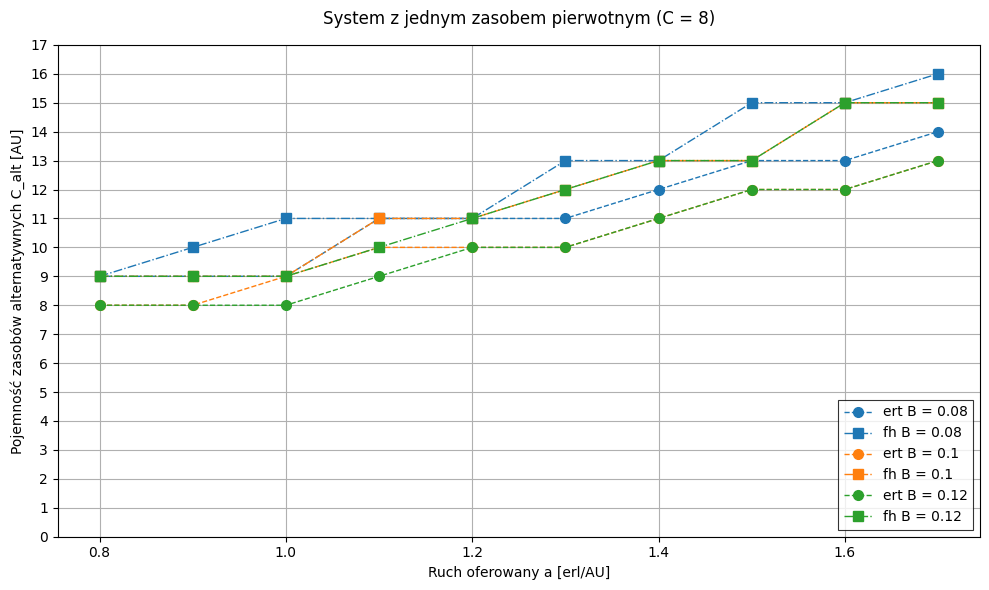

In [7]:
plot_results(
    a_vals_32,
    plot_32,
    B_list_32,
    title="System z jednym zasobem pierwotnym (C = 8)",
    filename="wykres_32.png"
)

### Podpunkt 3.3

In [8]:
# --- parametry 3.3 ---
C_list_33 = [3, 5]
A_alt_33 = 3.0
B_list_33 = [0.2, 0.4, 0.6]
a_min_33, a_max_33, a_step_33 = 0.8, 1.7, 0.1

outfile = "wyniki_33.txt"

with open(outfile, "w", encoding="utf-8") as f:
    def log(line: str):
        print(line)
        f.write(line + "\n")

    # --- nagłówek tabeli ---
    header = f"{'a':<6}"
    for i in range(len(B_list_33)):
        header += f"{f'e{i+1}_e':<7} "
    header += "  "
    for i in range(len(B_list_33)):
        header += f"{f'e{i+1}_fh':<7} "

    log("3.3")
    log(f"# C = {C_list_33}")
    log(f"# B = {B_list_33}")
    log(header)

    # --- pętle + zapisy do struktur na wykres ---
    a_vals_33 = []
    plot_33 = {'e': [[] for _ in B_list_33], 'fh': [[] for _ in B_list_33]}

    a = a_min_33
    while a <= a_max_33 + 1e-9:
        res = calc_row(a, C_list_33, A_alt_33, B_list_33)

        row = f"{a:<6.3g}"
        for v in res['e']:
            row += f"{v:<7} "
        row += "  "
        for v in res['fh']:
            row += f"{v:<7} "

        log(row)

        a_vals_33.append(a)
        for i in range(len(B_list_33)):
            plot_33['e'][i].append(res['e'][i])
            plot_33['fh'][i].append(res['fh'][i])

        a += a_step_33

print(f"\nZapisano wyniki do pliku: {outfile}")


3.3
# C = [3, 5]
# B = [0.2, 0.4, 0.6]
a     e1_e    e2_e    e3_e      e1_fh   e2_fh   e3_fh   
0.8   6       4       2         6       5       3       
0.9   6       4       2         8       5       4       
1     7       4       2         8       5       4       
1.1   7       4       2         8       6       4       
1.2   8       4       2         10      7       4       
1.3   8       5       2         10      7       4       
1.4   8       5       2         10      7       4       
1.5   9       5       2         11      7       6       
1.6   10      6       3         11      8       6       
1.7   11      6       3         12      8       6       

Zapisano wyniki do pliku: wyniki_33.txt


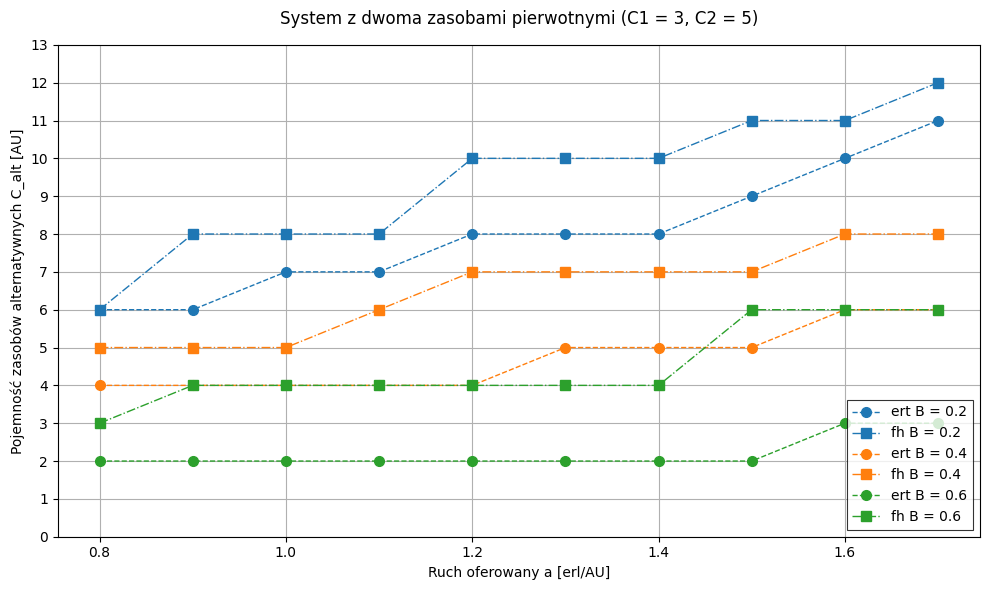

In [9]:
plot_results(
    a_vals_33,
    plot_33,
    B_list_33,
    title="System z dwoma zasobami pierwotnymi (C1 = 3, C2 = 5)",
    filename="wykres_33.png"
)
